In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime as dt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

Populating the interactive namespace from numpy and matplotlib


## Part 1: Extracting and Formatting the data

Here we are using a SQL query to select features from the SQLite database for only the state of California.

In [2]:
# Dataset available for download from https://www.kaggle.com/rtatman/188-million-us-wildfires
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
c = conn.cursor()
c.execute("""SELECT FIRE_Size, FIRE_SIZE_CLASS, DISCOVERY_DATE,
DISCOVERY_TIME, CONT_DATE, CONT_TIME, STAT_CAUSE_DESCR, FIPS_NAME,
LATITUDE, LONGITUDE
from Fires
where STATE = 'CA'""")
column_names = ['fire_size', 'fire_size_class',
               'discovery_date', 'discovery_time',
               'cont_date', 'cont_time',
               'start_cause_descr', 'county_name',
               'latitude', 'longitude']
raw_data = c.fetchall()
data_ar = np.array(raw_data)
fires = pd.DataFrame(data_ar, columns = [column_names])

In [3]:
fires.columns = fires.columns.get_level_values(0)
fires.shape

(189550, 10)

In [4]:
fires.head()

,fire_size,fire_size_class,discovery_date,discovery_time,cont_date,cont_time,start_cause_descr,county_name,latitude,longitude
0,0.1,A,2.4534e+06,1300,2.4534e+06,1730,Miscellaneous,Plumas,40.0369,-121.006
1,0.25,A,2.45314e+06,0845,2.45314e+06,1530,Lightning,Placer,38.9331,-120.404
2,0.1,A,2.45316e+06,1921,2.45316e+06,2024,Debris Burning,El Dorado,38.9842,-120.736
3,0.1,A,2.45318e+06,1600,2.45319e+06,1400,Lightning,Alpine,38.5592,-119.913
4,0.1,A,2.45318e+06,1600,2.45319e+06,1200,Lightning,Alpine,38.5592,-119.933


In [5]:
fires.dtypes

fire_size            object
fire_size_class      object
discovery_date       object
discovery_time       object
cont_date            object
cont_time            object
start_cause_descr    object
county_name          object
latitude             object
longitude            object
dtype: object

From the above, we can see that there are a few object features that should be numeric. Let's fix that.

In [6]:
obj = ["fire_size", "latitude", "longitude"]

for i in obj:
    fires[i] = fires[i].apply(pd.to_numeric, errors='coerce')
    
fires.dtypes

fire_size            float64
fire_size_class       object
discovery_date        object
discovery_time        object
cont_date             object
cont_time             object
start_cause_descr     object
county_name           object
latitude             float64
longitude            float64
dtype: object

#### Check for NA's

In [7]:
fires.isna().sum()

fire_size                 0
fire_size_class           0
discovery_date            0
discovery_time        79333
cont_date             97642
cont_time             98333
start_cause_descr         0
county_name          133329
latitude                  0
longitude                 0
dtype: int64

There are a considerable amount of NA values in this dataset. Unfortunately, we have no way of imputing the county name or any of the date and time features so we will have to drop them. Yet, even after dropping all the rows with NA values, we still have a large amount of data to work with.

In [8]:
fires.dropna(inplace=True)
fires.shape

(42370, 10)

#### Convert date time format

The data features are in Julian format so let's convert them to a more standard and readable format. 

In [9]:
fires['disc_clean_date'] = pd.to_datetime(fires['discovery_date'] - pd.Timestamp(0).to_julian_date(), unit='D')
#Convert containment date from julian to standard date
fires['cont_clean_date'] = pd.to_datetime(fires['cont_date'] - pd.Timestamp(0).to_julian_date(), unit='D')
# Year of fire
fires['discovery_year'] = fires['disc_clean_date'].dt.strftime('%Y')
#Day of month string
fires['discovery_month'] = fires['disc_clean_date'].dt.strftime('%b')
#Returns the weekday string
fires['discovery_weekday'] = fires['disc_clean_date'].dt.strftime('%a')
#Merge discovery date and time 
fires['disc_date_final'] = pd.to_datetime(fires.disc_clean_date.astype('str') + ' ' + fires.discovery_time, errors='coerce')
#Merge containment date and time 
fires['cont_date_final'] = pd.to_datetime(fires.cont_clean_date.astype('str') + ' ' + fires.cont_time, errors='coerce')

# drop columns with Julian format
fires = fires.drop(['discovery_date', 'discovery_time',
                          'cont_date', 'cont_time'], axis=1).reset_index(drop=True)
fires.head()

,fire_size,fire_size_class,start_cause_descr,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,discovery_month,discovery_weekday,disc_date_final,cont_date_final
0,0.10,A,Miscellaneous,Plumas,40.036944,-121.005833,2005-02-02,2005-02-02,2005,Feb,Wed,2005-02-02 13:00:00,2005-02-02 17:30:00
1,0.25,A,Lightning,Placer,38.933056,-120.404444,2004-05-12,2004-05-12,2004,May,Wed,2004-05-12 08:45:00,2004-05-12 15:30:00
2,0.10,A,Debris Burning,El Dorado,38.984167,-120.735556,2004-05-31,2004-05-31,2004,May,Mon,2004-05-31 19:21:00,2004-05-31 20:24:00
3,0.10,A,Lightning,Alpine,38.559167,-119.913333,2004-06-28,2004-07-03,2004,Jun,Mon,2004-06-28 16:00:00,2004-07-03 14:00:00
4,0.10,A,Lightning,Alpine,38.559167,-119.933056,2004-06-28,2004-07-03,2004,Jun,Mon,2004-06-28 16:00:00,2004-07-03 12:00:00


## Part 2: Exploratory Analysis

#### Number of fires per county

Let's start by seeing which counties are the most susceptible to fires.

Text(0, 0.5, 'Number of Fires')

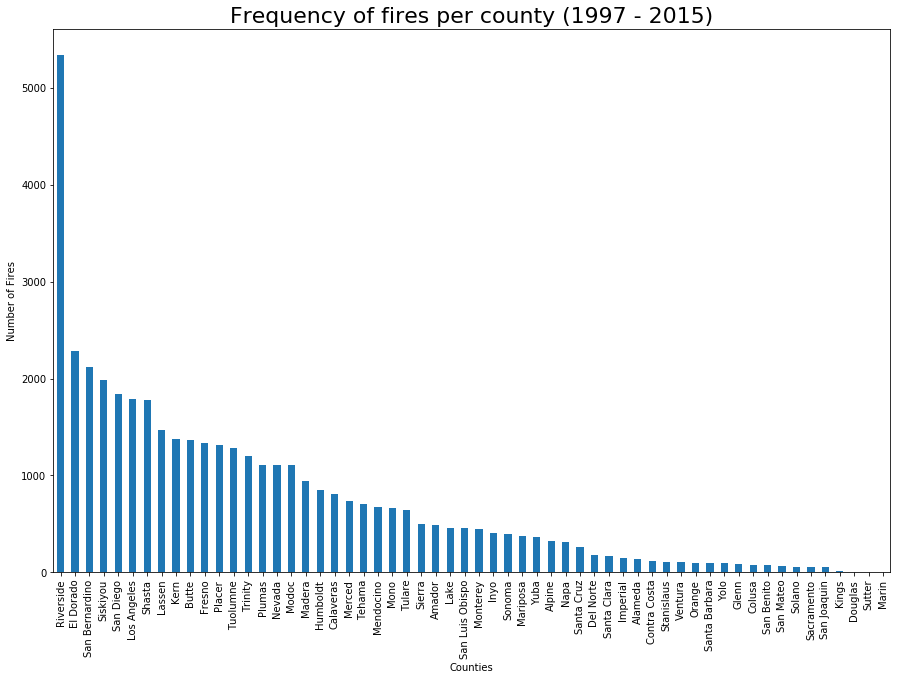

In [10]:
fig, ax = plt.subplots()
county_freq = fires.groupby('county_name').fire_size_class.count().sort_values(ascending=False).plot(
    ax=ax, kind='bar', figsize=(15, 10))

plt.title("Frequency of fires per county (1997 - 2015)", fontsize=22)
plt.xlabel("Counties")
plt.ylabel("Number of Fires")

It appears that the counties with the highest frequency of fires are all located in Southern California. This makes sense as Southern California is generally more hot and arid than Northern California. Let's see if that shows in a plot of the longitudes and latitudes of these fires.

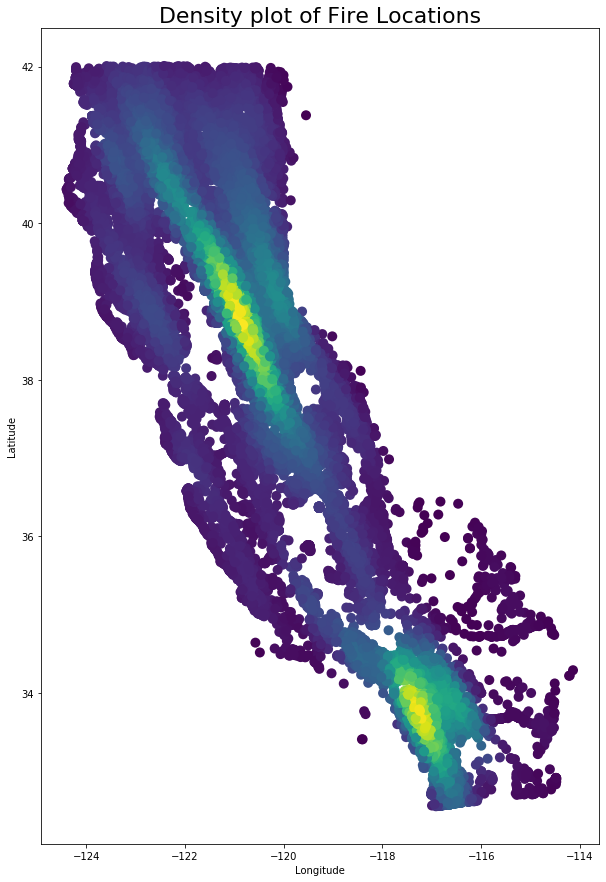

In [11]:
x = fires['longitude']
y = fires['latitude']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(10, 15))
ax.scatter(x, y, c=z, s=100, edgecolor='')

plt.title("Density plot of Fire Locations", fontsize=22)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Indeed there is a concentration of fires in the Riverside to San Diego region of Southern California but there is also a pretty strong concentration of fires on the eastern side of the Sierra Nevadas in Central California.

#### Distribution of fires over time

Next let's take a look at how the frequency of fires is distributed over the years

Text(0, 0.5, 'Frequency')

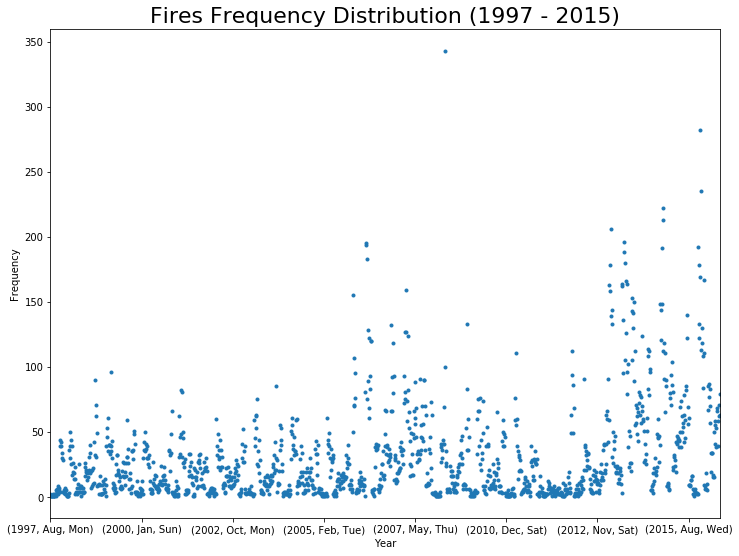

In [12]:
fig, ax = plt.subplots()
x = fires.groupby(['discovery_year', 'discovery_month', 'discovery_weekday']).size()

x.plot(ax=ax, style='.', figsize=(12,9))


plt.title("Fires Frequency Distribution (1997 - 2015)", fontsize=22)
plt.xlabel("Year")
plt.ylabel("Frequency")

It certainly looks like the frequency of fires is generally increasing, especially in more recent years. However, this might be more clearly visualized with a histogram.

Text(0, 0.5, 'Frequency')

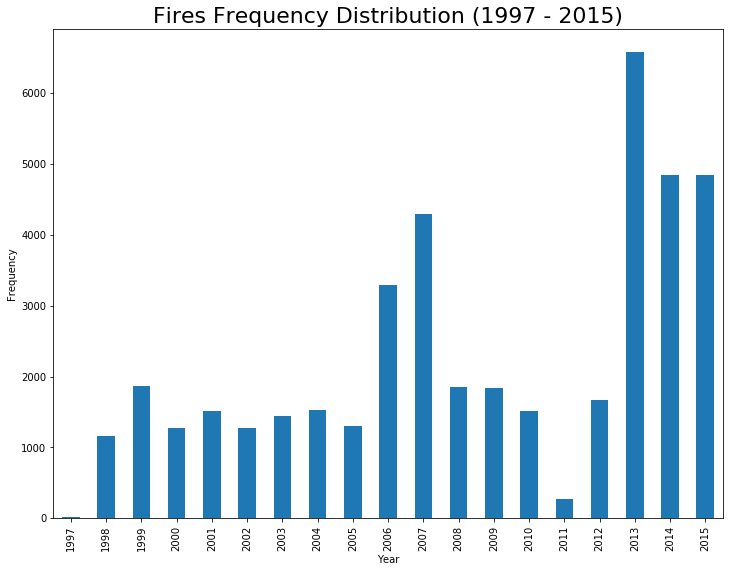

In [13]:
# sort data by year
fires.sort_values("discovery_year", inplace=True)

fig, ax = plt.subplots()
fires['discovery_year'].value_counts().sort_index().plot(ax=ax, kind='bar', figsize=(12,9))
plt.title("Fires Frequency Distribution (1997 - 2015)", fontsize=22)
plt.xlabel("Year")
plt.ylabel("Frequency")

Now we can more clearly see that the distribution of fires over the years is skewed to the left and, therefore, demonstrates an increasing trend. We can look further into this by examining the distribution of fire size classes.

In [14]:
# Function to plot labelled histograms of frequency of features over another feature
def plot_histogram_labelled(df, x, y, title, dropna=False):
    
    if (dropna):
        plot_df = df.dropna(inplace=False)
    else:
        plot_df = df
    
    x_var = x
    groupby_var = y
    plot_df_agg = plot_df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [plot_df[x_var].values.tolist() for i, plot_df in plot_df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, plot_df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(plot_df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(title, fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    # plt.ylim(0, 40)
    plt.xticks(ticks=bins, labels=np.unique(plot_df[x_var]).tolist(), rotation=90, horizontalalignment='left')
    plt.show()

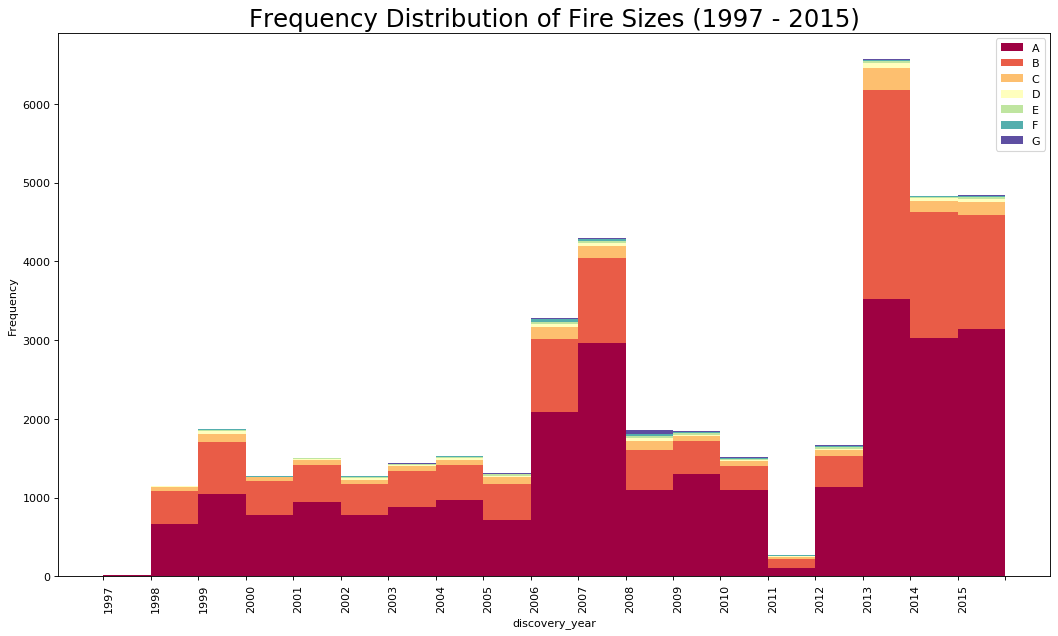

In [15]:
title = "Frequency Distribution of Fire Sizes (1997 - 2015)"
plot_histogram_labelled(fires, "discovery_year", "fire_size_class", title)

In the above histogram, we can see that the smaller fire sizes (class A - C) dominate the frequency distribution. In order to get a better idea of the distribution of larger fires, we'll have to remove the smaller fires.

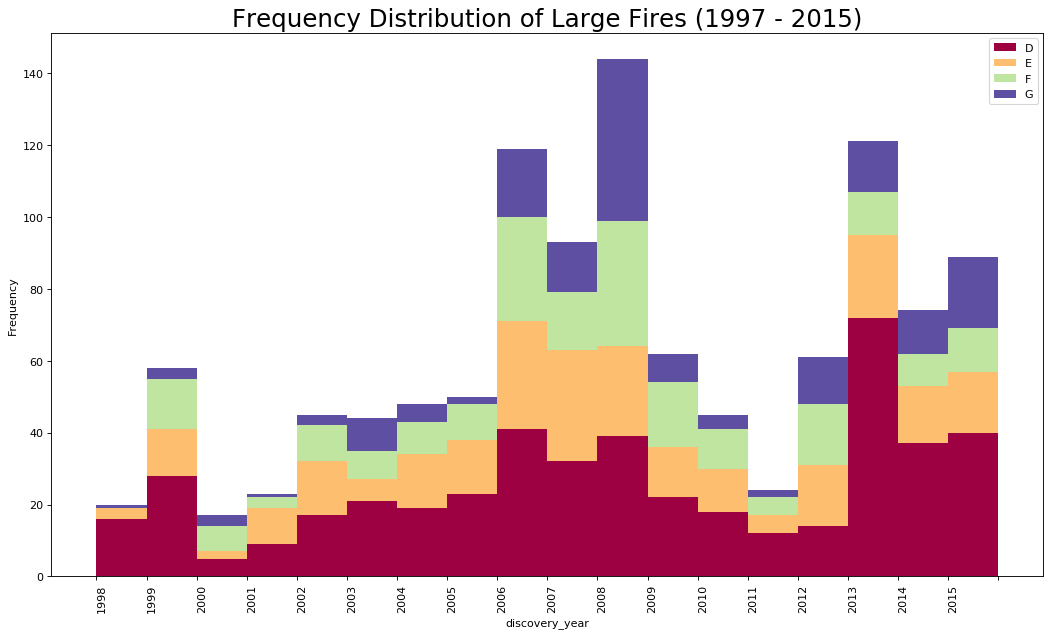

In [16]:
title = "Frequency Distribution of Large Fires (1997 - 2015)"
temp = fires[fires["fire_size_class"].isin(["D", "E", "F", "G"])]
plot_histogram_labelled(temp, "discovery_year", "fire_size_class", title)

The frequency of larger fires appears to be somewhat normally distributed. Given the effect that climate change has on the frequency of fires, we would expect there to be an increase in the frequency of larger fires as the years increase. However, this data only shows about 18 years of data so it could be that we would see this trend if we had data going further back in time.

Next let's look at the distribution of the causes of these fires over the years.

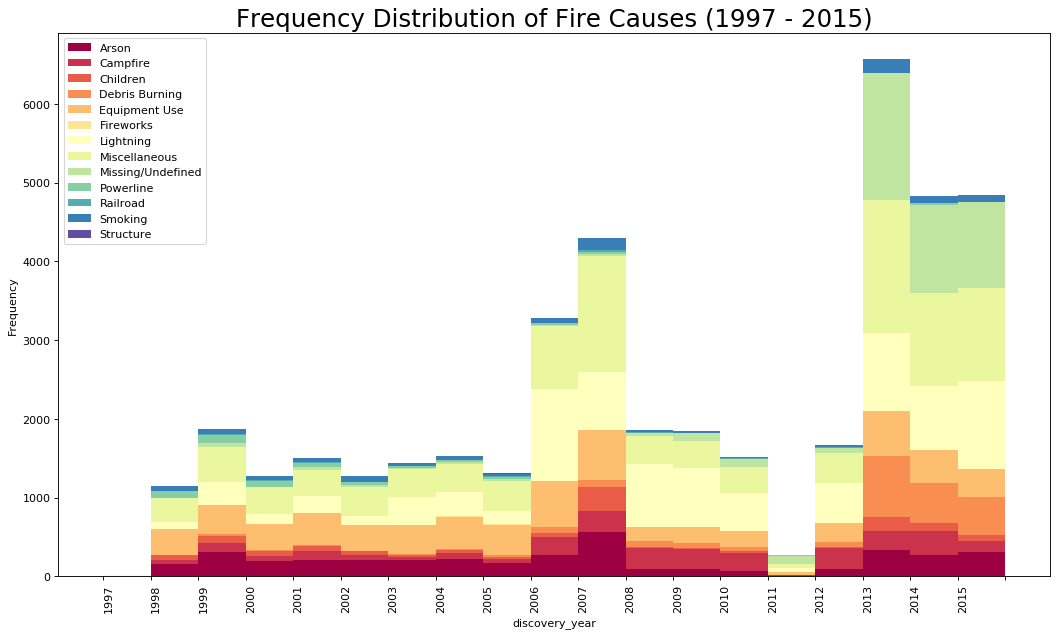

In [17]:
title = "Frequency Distribution of Fire Causes (1997 - 2015)"
plot_histogram_labelled(fires, "discovery_year", "start_cause_descr", title)

It looks like the most common cause of fires is either miscellaneous or missing/undefined, which doesn't tell us much unfortunately. In more recent years, powerlines seem to be the cause of a majority of fires. This fits in well with current events where the utility company PG&E has been forced to declare bankruptcy due to lawsuits over fires caused by their downed powerlines. 

## Part 3: Feature Engineering

The current set of features is relatively small and we could improve our models by adding more.

#### Add feature for seasons and a separate boolean feature for if it's fire season or not.

We would expect the nature of fires to change with each different season, especially during the fire season. The fire season in California is during the fall when winds pick up but the climate is still hot and dry.

In [18]:
fires['Season'] = None
fires['is_fire_season'] = 0

fall = ['Sep', 'Oct', 'Nov']
winter = ['Dec', 'Jan', 'Feb']
spring = ['Mar', 'Apr', 'May']
summer = ['Jun', 'Jul', 'Aug']

for i, row in fires.iterrows():
    month = row['discovery_month']
    if month in fall:
        fires.at[i, 'Season'] = 'Fall'
        fires.at[i, 'is_fire_season'] = 1
    elif month in winter:
        fires.at[i, 'Season'] = 'Winter'
    elif month in spring:
        fires.at[i, 'Season'] = 'Spring'
    else:
        fires.at[i, 'Season'] = 'Summer'

fires.head()    

,fire_size,fire_size_class,start_cause_descr,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,discovery_month,discovery_weekday,disc_date_final,cont_date_final,Season,is_fire_season
9703,0.1,A,Lightning,Siskiyou,41.749031,-121.973439,1997-07-28,1997-07-28,1997,Jul,Mon,1997-07-28 20:15:00,1997-07-28 21:00:00,Summer,0
6910,0.1,A,Campfire,Tuolumne,38.175000,-120.151667,1997-11-24,1997-11-24,1997,Nov,Mon,1997-11-24 14:30:00,1997-11-24 17:30:00,Fall,1
6911,0.1,A,Arson,Tuolumne,37.836667,-120.000000,1997-10-21,1997-10-21,1997,Oct,Tue,1997-10-21 11:00:00,1997-10-21 13:00:00,Fall,1
6912,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1
6913,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1


#### Add a feature for the duration of each fire

The duration of each fire should be a useful and predictive feature.

In [19]:
fires.reset_index(inplace=True, drop=True)
fires['Duration'] = (fires['cont_date_final'] - fires['disc_date_final'])
fires['Duration_sec'] = 0.0
for i, row in fires.iterrows():
    fires.at[i, 'Duration_sec'] = fires['Duration'].iloc[i].total_seconds()
fires.head()

,fire_size,fire_size_class,start_cause_descr,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,discovery_month,discovery_weekday,disc_date_final,cont_date_final,Season,is_fire_season,Duration,Duration_sec
0,0.1,A,Lightning,Siskiyou,41.749031,-121.973439,1997-07-28,1997-07-28,1997,Jul,Mon,1997-07-28 20:15:00,1997-07-28 21:00:00,Summer,0,00:45:00,2700.0
1,0.1,A,Campfire,Tuolumne,38.175000,-120.151667,1997-11-24,1997-11-24,1997,Nov,Mon,1997-11-24 14:30:00,1997-11-24 17:30:00,Fall,1,03:00:00,10800.0
2,0.1,A,Arson,Tuolumne,37.836667,-120.000000,1997-10-21,1997-10-21,1997,Oct,Tue,1997-10-21 11:00:00,1997-10-21 13:00:00,Fall,1,02:00:00,7200.0
3,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1,00:05:00,300.0
4,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1,00:05:00,300.0


#### Bucket the fire cause

The feature "start_cause_descr" will be more useful later when we are trying to classify the cause of each fire if we bucket it into three different categories: Accidental (caused by humans), Arson (intentionally caused by humans), and natural. In doing so, we will also need to drop fires with the cause "Miscellaneous" and "Missing/Undefined" as we can't be sure which category they belong to.

In [20]:
# Drop Miscellaneous and Missing/Undefined
fires = fires[~fires.start_cause_descr.str.contains('Miscellaneous')]
fires = fires[~fires.start_cause_descr.str.contains('Missing')]

# Bucket fire start descriptions
fires['Cause'] = None
for i, row in fires.iterrows():
    if row['start_cause_descr'] == 'Arson':
        fires.at[i, 'Cause'] = 'Arson'
    elif row['start_cause_descr'] == 'Lightning':
        fires.at[i, 'Cause'] = 'Natural'
    else:
        fires.at[i, 'Cause'] = 'Accidental'
fires.head()

,fire_size,fire_size_class,start_cause_descr,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,discovery_month,discovery_weekday,disc_date_final,cont_date_final,Season,is_fire_season,Duration,Duration_sec,Cause
0,0.1,A,Lightning,Siskiyou,41.749031,-121.973439,1997-07-28,1997-07-28,1997,Jul,Mon,1997-07-28 20:15:00,1997-07-28 21:00:00,Summer,0,00:45:00,2700.0,Natural
1,0.1,A,Campfire,Tuolumne,38.175000,-120.151667,1997-11-24,1997-11-24,1997,Nov,Mon,1997-11-24 14:30:00,1997-11-24 17:30:00,Fall,1,03:00:00,10800.0,Accidental
2,0.1,A,Arson,Tuolumne,37.836667,-120.000000,1997-10-21,1997-10-21,1997,Oct,Tue,1997-10-21 11:00:00,1997-10-21 13:00:00,Fall,1,02:00:00,7200.0,Arson
3,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1,00:05:00,300.0,Arson
4,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1,00:05:00,300.0,Arson


#### Further bucket the fire cause to natural versus human caused

This will be useful later when we use it as the label for our binary classifier.

In [21]:
fires['Lightning'] = 0
for i, row in fires.iterrows():
    if row['start_cause_descr'] == 'Lightning':
        fires.at[i, 'Lightning'] = 1
    else:
        fires.at[i, 'Lightning'] = 0
fires.head()

,fire_size,fire_size_class,start_cause_descr,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,discovery_month,discovery_weekday,disc_date_final,cont_date_final,Season,is_fire_season,Duration,Duration_sec,Cause,Lightning
0,0.1,A,Lightning,Siskiyou,41.749031,-121.973439,1997-07-28,1997-07-28,1997,Jul,Mon,1997-07-28 20:15:00,1997-07-28 21:00:00,Summer,0,00:45:00,2700.0,Natural,1
1,0.1,A,Campfire,Tuolumne,38.175000,-120.151667,1997-11-24,1997-11-24,1997,Nov,Mon,1997-11-24 14:30:00,1997-11-24 17:30:00,Fall,1,03:00:00,10800.0,Accidental,0
2,0.1,A,Arson,Tuolumne,37.836667,-120.000000,1997-10-21,1997-10-21,1997,Oct,Tue,1997-10-21 11:00:00,1997-10-21 13:00:00,Fall,1,02:00:00,7200.0,Arson,0
3,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1,00:05:00,300.0,Arson,0
4,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,Fri,1997-10-31 15:50:00,1997-10-31 15:55:00,Fall,1,00:05:00,300.0,Arson,0


#### Get proportion of each cause by county

Our models could benefit from having features that contain information on the history of fire causes in each county. For example, if a particular county has a history of arson, it may be more likely that it will happen again. We can implement this by getting the proportion of fire causes for each county. 

In [22]:
# split the data into the three different causes
arson_fires = fires[fires.Cause == 'Arson']
natural_fires = fires[fires.Cause == 'Natural']
accidental_fires = fires[fires.Cause == 'Accidental']

# get the counts of each cause and total count
fires_count = pd.DataFrame(fires.groupby('county_name').size())
arson_count = pd.DataFrame(arson_fires.groupby('county_name').size())
natural_count = pd.DataFrame(natural_fires.groupby('county_name').size())
accidental_count = pd.DataFrame(accidental_fires.groupby('county_name').size())
 
cols = ['county_name', 'count']
fires_count.reset_index(inplace=True)
fires_count.columns = cols

arson_count.reset_index(inplace=True)
arson_count.columns = cols

natural_count.reset_index(inplace=True)
natural_count.columns = cols

accidental_count.reset_index(inplace=True)
accidental_count.columns = cols

arson_freq = {}
natural_freq = {}
accidental_freq = {}

# iterate through the total count and get the proportion for each county
for i, row in fires_count.iterrows():
    county = row['county_name']
    if county in arson_count['county_name'].values:
        count = float(arson_count.loc[arson_count['county_name'] == county]['count'])
        arson_freq[county] = count/float(row['count'])
    else:
        arson_freq[county] = 0
        
    if county in natural_count['county_name'].values:
        count = float(natural_count.loc[natural_count['county_name'] == county]['count'])
        natural_freq[county] = count/float(row['count'])
    else:
        natural_freq[county] = 0
        
    if county in accidental_count['county_name'].values:
        count = float(accidental_count.loc[accidental_count['county_name'] == county]['count'])
        accidental_freq[county] = count/float(row['count'])
    else:
        accidental_freq[county] = 0
        
# add proportions to dataframe 
fires['arson_freq'] = None
fires['natural_freq'] = None
fires['accidental_freq'] = None
for i, row in fires.iterrows():
    county = row['county_name']
    fires.at[i, 'arson_freq'] = arson_freq[county]
    fires.at[i, 'natural_freq'] = natural_freq[county]
    fires.at[i, 'accidental_freq'] = accidental_freq[county]
    
fires.head()

,fire_size,fire_size_class,start_cause_descr,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,discovery_month,...,cont_date_final,Season,is_fire_season,Duration,Duration_sec,Cause,Lightning,arson_freq,natural_freq,accidental_freq
0,0.1,A,Lightning,Siskiyou,41.749031,-121.973439,1997-07-28,1997-07-28,1997,Jul,...,1997-07-28 21:00:00,Summer,0,00:45:00,2700.0,Natural,1,0.0570253,0.726044,0.216931
1,0.1,A,Campfire,Tuolumne,38.175000,-120.151667,1997-11-24,1997-11-24,1997,Nov,...,1997-11-24 17:30:00,Fall,1,03:00:00,10800.0,Accidental,0,0.204413,0.212544,0.583043
2,0.1,A,Arson,Tuolumne,37.836667,-120.000000,1997-10-21,1997-10-21,1997,Oct,...,1997-10-21 13:00:00,Fall,1,02:00:00,7200.0,Arson,0,0.204413,0.212544,0.583043
3,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,...,1997-10-31 15:55:00,Fall,1,00:05:00,300.0,Arson,0,0.204413,0.212544,0.583043
4,0.1,A,Arson,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,Oct,...,1997-10-31 15:55:00,Fall,1,00:05:00,300.0,Arson,0,0.204413,0.212544,0.583043


#### Modify categorical features so that they can be fed into the models

In [23]:
Fires = fires.copy()

# Convert fire class to integers
Fires['fire_size_class'] = le.fit_transform(Fires['fire_size_class'])

# One hot encode months and weekdays
dummy_cond = pd.get_dummies(Fires[['discovery_month', 'discovery_weekday', 'Season', 'start_cause_descr']])

Fires = pd.concat([Fires, dummy_cond], axis=1)

# drop categorical columns
Fires.drop(['discovery_month', 'discovery_weekday', 'Season', 'start_cause_descr'], axis=1, inplace=True)

Fires.head()

,fire_size,fire_size_class,county_name,latitude,longitude,disc_clean_date,cont_clean_date,discovery_year,disc_date_final,cont_date_final,...,start_cause_descr_Campfire,start_cause_descr_Children,start_cause_descr_Debris Burning,start_cause_descr_Equipment Use,start_cause_descr_Fireworks,start_cause_descr_Lightning,start_cause_descr_Powerline,start_cause_descr_Railroad,start_cause_descr_Smoking,start_cause_descr_Structure
0,0.1,0,Siskiyou,41.749031,-121.973439,1997-07-28,1997-07-28,1997,1997-07-28 20:15:00,1997-07-28 21:00:00,...,0,0,0,0,0,1,0,0,0,0
1,0.1,0,Tuolumne,38.175000,-120.151667,1997-11-24,1997-11-24,1997,1997-11-24 14:30:00,1997-11-24 17:30:00,...,1,0,0,0,0,0,0,0,0,0
2,0.1,0,Tuolumne,37.836667,-120.000000,1997-10-21,1997-10-21,1997,1997-10-21 11:00:00,1997-10-21 13:00:00,...,0,0,0,0,0,0,0,0,0,0
3,0.1,0,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,1997-10-31 15:50:00,1997-10-31 15:55:00,...,0,0,0,0,0,0,0,0,0,0
4,0.1,0,Tuolumne,38.050000,-119.925000,1997-10-31,1997-10-31,1997,1997-10-31 15:50:00,1997-10-31 15:55:00,...,0,0,0,0,0,0,0,0,0,0


## Part 4: Labeling the Fire Size Class

Can we predict the size class of a fire given the features we created in the previous section? And, if so, what is the best model to use? Let's start by training a decision tree on the data. 

In [24]:
# Split into feature and label sets
X = Fires.drop(['fire_size_class', 'fire_size', 'county_name', 'disc_clean_date', 'cont_clean_date',
                  'disc_date_final', 'cont_date_final', 'Duration', 'Cause', 'Lightning'], axis=1)
y = Fires['fire_size_class']

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 10)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

In [25]:
# Function for printing the features in order of their importance to the model
def get_feature_importance(pred, clf):
    feat_importance = {}
    for name, score in zip(pred.columns, clf.feature_importances_):
        feat_importance[name] = score
    sorted_feat = sorted((value, key) for (key,value) in feat_importance.items())
    for feat in sorted_feat[::-1]:
        print(feat)

In [26]:
print('\n'"Accuracy on training set: %f" % clf.score(x_train, y_train))
print('\n'"Accuracy on test set: %f \n" % clf.score(x_test, y_test))

print(classification_report(y_test,y_pred))
get_feature_importance(X, clf)


Accuracy on training set: 0.729327

Accuracy on test set: 0.672534 

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      3497
           1       0.51      0.36      0.42      1596
           2       0.22      0.15      0.18       205
           3       0.30      0.09      0.14        68
           4       0.07      0.03      0.04        36
           5       0.10      0.07      0.08        30
           6       0.26      0.27      0.27        22

    accuracy                           0.67      5454
   macro avg       0.31      0.26      0.27      5454
weighted avg       0.64      0.67      0.65      5454

(0.3748702804866037, 'Duration_sec')
(0.1380753577831256, 'latitude')
(0.08593842399058581, 'longitude')
(0.0814079208684272, 'start_cause_descr_Lightning')
(0.07247490016811765, 'discovery_year')
(0.06337436317506702, 'start_cause_descr_Campfire')
(0.041762039883347916, 'accidental_freq')
(0.0354920675012615, 'natural_freq')
(0.02

From the above metrics we can see that our decision tree classifier leaves something to be desired. The accuracy on the test set is fairly low and the precision and recall is unacceptably low for all but the most numerous size class. 

Further, the feature importance output tells us that the duration of the fire in seconds is by far the best predictor of its size. This makes intuitive sense and speaks to the importance of creating new features as fire duration was not in the original dataset.

#### Improving model performance

There are a few things we can do to improve the accuracy of our model: 

1) The most obvious solution would be to try a different model. But while we are at it, we might as well try several different models and see which one performs the best.

2) We can make our classification problem binary by bucketing the fire sizes into small (classes A, B, C, and D) versus large (classes E, F, and G) fires. 

3) Instead of randomly splitting the data into train and test sets, we can use k-fold cross validation. This is a more time consuming way of training our models but it should yield more robust results. 

To summarize, below we will use stratified 10-fold cross validation to train a decision tree, random forest, K-Nearest Neighbors, logistic regression, and AdaBoost classifier to see which model performs best at classifying small versus large fires. 

In [27]:
# This function takes as input a list of classifiers, test and train data. It evaluates the models
# using stratifiedKfold (10 by default) and outputs the average Accuracy and AUC scores. Additionally,
# it also plots the ROC curve for all the classifiers

def Evaluation_Metrics(clfs, X, y, n_splits=10):
    plt.figure(figsize=(13, 10))

    for i, clf in enumerate(clfs):
        skf_acc = 0.
        skf_auc = 0.
    
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            # Split the data into training and testing sets.
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model and get predictions.
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            # Calculate and sum the accuracy and AUC scores.
            skf_acc += accuracy_score(y_test, y_pred)
            skf_auc += roc_auc_score(y_test, y_pred)

        # Get the mean accuracy and AUC scores.
        skf_acc = round(skf_acc / n_splits, 3)
        skf_auc = round(skf_auc / n_splits, 3)

        # Get the classifier name.
        clf_name = str(type(clf)).split('.')[-1][:-2]

        # Print the AUC and ACC scores for the particular model
        print("{} \n\tAcc: {}\n\tAUC: {}\n".format(clf_name, skf_acc, skf_auc))

        # Get FPR, TPR, and corresponding thresholds.
        fpr, tpr, thresh = roc_curve(y_test, y_pred)

        # Plot the ROC curve.
        plt.plot(fpr, tpr, linewidth=2.5,
                 label="AUC: {}, {}".format(skf_auc, clf_name))
        
    # Plot baseline ,i.e, y = x line segment.
    plt.plot([0, 1], [0, 1], '--', linewidth=1, color='gray')

    # Specify plot details.
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
    plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.yticks(fontsize=12)
    plt.legend(loc=0, fontsize=15)
    plt.title("ROC Curves", fontsize=17);      

In [28]:
data = Fires.copy()

# Transform fire_size_class into binary feature for small versus large fires
data['fire_size_class'] = data['fire_size_class'].apply(lambda x: 0 if (x <= 3) else 1)

# Split into feature and label sets
X = data.drop(['fire_size_class', 'fire_size', 'county_name', 'disc_clean_date', 'cont_clean_date',
                  'disc_date_final', 'cont_date_final', 'Duration', 'Cause', 'Lightning'], axis=1)
obj = ["discovery_year", "arson_freq", "natural_freq", "accidental_freq"]

for i in obj:
    X[i] = X[i].apply(pd.to_numeric, errors='coerce')
    
y = data['fire_size_class']

In [29]:
clfs = [RandomForestClassifier(criterion='gini', n_estimators= 500, max_depth = 20),
        AdaBoostClassifier(n_estimators= 200),
        DecisionTreeClassifier(criterion='gini', splitter='best'),
        KNeighborsClassifier(n_neighbors=3),
        LogisticRegression(solver='lbfgs', max_iter=2000)]

RandomForestClassifier 
	Acc: 0.986
	AUC: 0.615

AdaBoostClassifier 
	Acc: 0.984
	AUC: 0.637

DecisionTreeClassifier 
	Acc: 0.98
	AUC: 0.696

KNeighborsClassifier 
	Acc: 0.982
	AUC: 0.627

LogisticRegression 
	Acc: 0.984
	AUC: 0.551



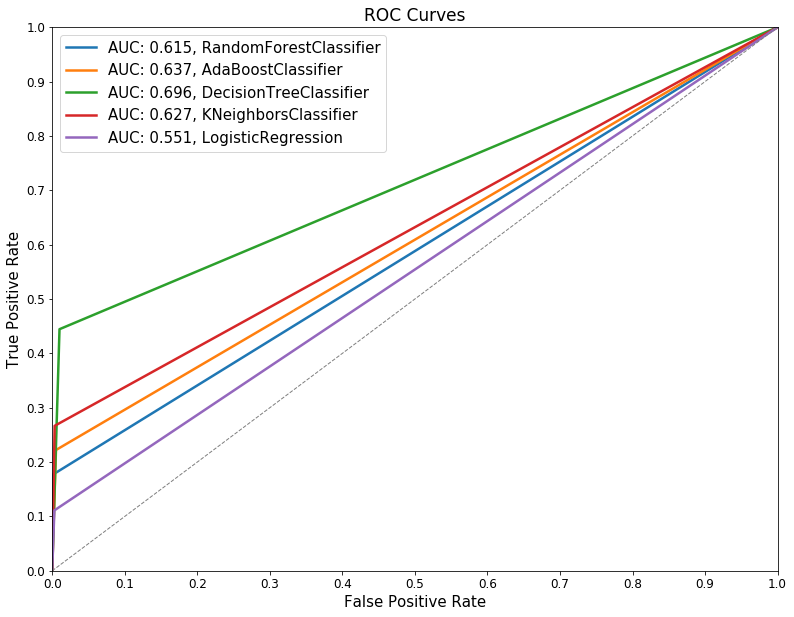

In [30]:
Evaluation_Metrics(clfs, X, y)

From the above output we can see that the accuracy of all models on the testing set improved drastically. However, accuracy doesn't tell the whole story. Especially given our data where there are many more small fires than there are large, a model could be decently accurate if it just labeled each instance as a small fire. A better and more frequently used metric for model performance is ROC AUC. Under this metric, we can see that the decision tree classifier performs the best. We may be able to further improve the performance of these models by bringing in data from another source. Information such as wind speed and humidity at the time of these fires would surely be an excellent predictor of the fire size.

## Part 5: Classify the Cause of Fires

Given our feature set, can we predict the start cause of fires? Again, let's start with a decision tree as it performed the best out of all the models in the previous section.

In [31]:
fires_cause = fires.copy()

# Convert fire class to integers
fires_cause['fire_size_class'] = le.fit_transform(fires_cause['fire_size_class'])

# One hot encode months and weekdays
dummy_cond = pd.get_dummies(fires_cause[['discovery_month', 'discovery_weekday', 'Season']])

fires_cause = pd.concat([fires_cause, dummy_cond], axis=1)

# drop categorical columns
fires_cause.drop(['discovery_month', 'discovery_weekday', 'Season'], axis=1, inplace=True)



X = fires_cause.drop(['Cause', 'Lightning', 'start_cause_descr','county_name', 'disc_clean_date', 'cont_clean_date',
                  'disc_date_final', 'cont_date_final', 'Duration'], axis=1)
# X.drop(X.loc[:, 'start_cause_descr_Arson':'start_cause_descr_Structure'].columns, axis=1, inplace=True)
y = fires_cause['start_cause_descr']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 20)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

In [32]:
print('\n'"Accuracy on training set: %f" % clf.score(x_train, y_train))
print('\n'"Accuracy on test set: %f \n" % clf.score(x_test, y_test))

print(classification_report(y_test,y_pred))
get_feature_importance(X, clf)


Accuracy on training set: 0.982811

Accuracy on test set: 0.513568 

                precision    recall  f1-score   support

         Arson       0.34      0.34      0.34       744
      Campfire       0.39      0.38      0.39       565
      Children       0.19      0.18      0.19       234
Debris Burning       0.42      0.45      0.44       466
 Equipment Use       0.47      0.47      0.47      1246
     Fireworks       0.00      0.00      0.00         4
     Lightning       0.77      0.77      0.77      1834
     Powerline       0.31      0.26      0.28       114
      Railroad       0.06      0.07      0.06        14
       Smoking       0.21      0.21      0.21       228
     Structure       0.00      0.00      0.00         5

      accuracy                           0.51      5454
     macro avg       0.29      0.29      0.29      5454
  weighted avg       0.51      0.51      0.51      5454

(0.20669636723058465, 'Duration_sec')
(0.15038000108772148, 'longitude')
(0.14723305350

As with our initial attempt at a decision tree in the previous section, this model has much room for improvement. Let's try the same techniques we used in the previous section to improve model performance, except now we will make the classification binary by seeing if we can label if a fire was human caused or natural.

In [33]:
data_2 = Fires.copy()

X = data_2.drop(['Cause', 'Lightning', 'county_name', 'disc_clean_date', 'cont_clean_date',
                  'disc_date_final', 'cont_date_final', 'Duration'], axis=1)
X.drop(X.loc[:, 'start_cause_descr_Arson':'start_cause_descr_Structure'].columns, axis=1, inplace=True)
y = data_2['Lightning']

obj = ["discovery_year", "arson_freq", "natural_freq", "accidental_freq"]

for i in obj:
    X[i] = X[i].apply(pd.to_numeric, errors='coerce')

In [34]:
clfs = [RandomForestClassifier(n_estimators= 500, max_depth = 30),
        AdaBoostClassifier(n_estimators= 200),
        DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10),
        KNeighborsClassifier(n_neighbors=9),
        LogisticRegression(solver='lbfgs', max_iter=1000)]

RandomForestClassifier 
	Acc: 0.899
	AUC: 0.881

AdaBoostClassifier 
	Acc: 0.87
	AUC: 0.848

DecisionTreeClassifier 
	Acc: 0.867
	AUC: 0.847

KNeighborsClassifier 
	Acc: 0.799
	AUC: 0.773

LogisticRegression 
	Acc: 0.723
	AUC: 0.604



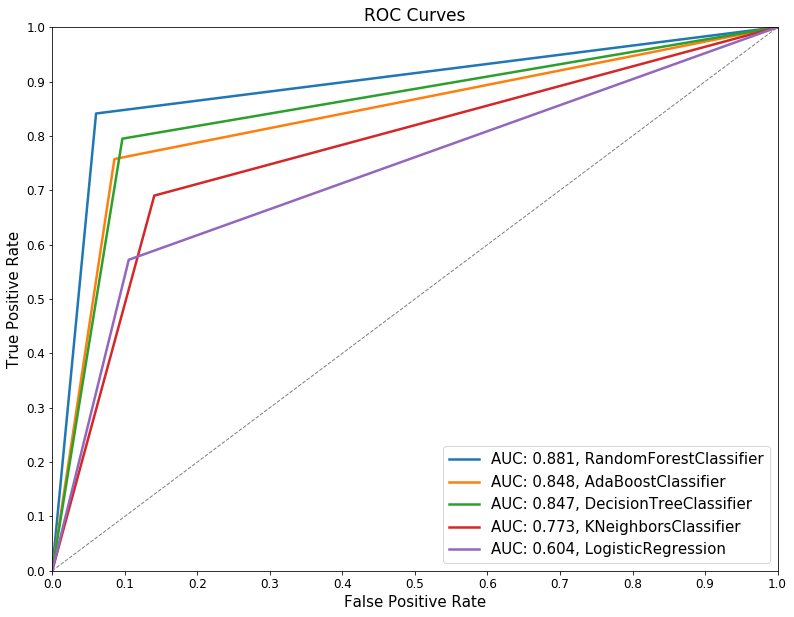

In [35]:
Evaluation_Metrics(clfs, X, y)

It seems the techniques we employed above have yielded models with both high accuracy and high AUC. The random forest classifier performs particularly well. Still, it could most likely be further improved by the addition of outside data as mentioned above. 